In [1]:
from keras.applications import resnet50
import keras
import pandas as pd
import numpy as np
from skimage import io,transform
import os
import sys
model_name = 'ResNet_RealSpam'

Using TensorFlow backend.


In [2]:
# counter = 0
# spamFolder = '../Images/SpamReal/Spam/'
# imageFiles = os.listdir(spamFolder)
# total = len(imageFiles)
# spam_images = []
# for image_path in imageFiles:
#     img = io.imread(os.path.join(spamFolder,image_path))
#     img = transform.resize(img, (64,64,3))
#     spam_images.append(img)
#     counter += 1
#     sys.stdout.write("\rProcessed: {0}/{1}".format(counter, total))
#     sys.stdout.flush()
# print('')
# counterA = 0
# realFolder = '../Images/SpamReal/Real/'
# imageFiles = os.listdir(realFolder)
# total = len(imageFiles)    
# real_images = []
# for image_path in os.listdir(realFolder):
#     img = io.imread(os.path.join(realFolder,image_path))
#     img = transform.resize(img, (64,64,3))
#     real_images.append(img)
#     counterA += 1
#     sys.stdout.write("\rProcessed: {0}/{1}".format(counterA, total))
#     sys.stdout.flush()
    
# x = np.array(spam_images+real_images)
# y = np.array(([0] * len(spam_images)) + ([1] * len(real_images)))
# y = keras.utils.to_categorical(y, 2)

# import random
# c = list(zip(x, y))
# random.shuffle(c)
# x, y = zip(*c)
# x = np.array(x)
# y = np.array(y)
# np.save('../Images/SpamReal/spamreal_x.npy', x)
# np.save('../Images/SpamReal/spamreal_y.npy', y)

In [3]:
x = np.load('../Images/SpamReal/spamreal_x.npy')
y = np.load('../Images/SpamReal/spamreal_y.npy')

In [4]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=7)

In [5]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = "3"

In [6]:
from keras.layers import GlobalAveragePooling2D, Dropout, Dense
from keras.models import Model
base = resnet50.ResNet50(include_top=False, weights=None, classes=2, input_shape=(64,64,3))
temp = base.output
temp = GlobalAveragePooling2D()(temp)
temp = Dropout(0.7)(temp)
predictions = Dense(2, activation= 'softmax')(temp)
model = Model(inputs = base.input, outputs = predictions)

/home/smsayeda/.local/lib/python3.5/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [9]:
from keras.callbacks import ModelCheckpoint
model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])

filepath="%s.best.hdf5" % model_name
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

hist = model.fit([x_train], y_train, batch_size=32, epochs=20, validation_data=([x_test], y_test), verbose=1, callbacks=callbacks_list)

Train on 8397 samples, validate on 2100 samples
Epoch 1/20
8397/8397 [==============================] - 22s 3ms/step - loss: 0.8230 - acc: 0.7222 - val_loss: 6.9862 - val_acc: 0.5638

Epoch 00001: val_loss improved from inf to 6.98621, saving model to ResNet_RealSpam.best.hdf5
Epoch 2/20
8397/8397 [==============================] - 18s 2ms/step - loss: 0.5166 - acc: 0.8173 - val_loss: 6.9069 - val_acc: 0.5648

Epoch 00002: val_loss improved from 6.98621 to 6.90691, saving model to ResNet_RealSpam.best.hdf5
Epoch 3/20
8397/8397 [==============================] - 18s 2ms/step - loss: 0.4160 - acc: 0.8332 - val_loss: 3.3587 - val_acc: 0.7286

Epoch 00003: val_loss improved from 6.90691 to 3.35868, saving model to ResNet_RealSpam.best.hdf5
Epoch 4/20
8397/8397 [==============================] - 18s 2ms/step - loss: 0.3633 - acc: 0.8619 - val_loss: 7.4040 - val_acc: 0.4624

Epoch 00004: val_loss did not improve from 3.35868
Epoch 5/20
8397/8397 [==============================] - 18s 2ms/ste

In [11]:
# serialize model to JSON
model_json = model.to_json()
with open("%s.json" % model_name, "w") as json_file:
    json_file.write(model_json)
    
# # serialize weights to HDF5
model.save_weights("%s.h5" % model_name)
print("Saved model to disk")

Saved model to disk


In [7]:
from keras.models import model_from_json
# load json and create model
json_file = open('%s.json' % model_name, 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)
# load weights into new model
model.load_weights("%s.h5" % model_name)
print("Loaded model from disk")

model.compile(loss='binary_crossentropy',
              optimizer='sgd',
              metrics=['acc'])

Loaded model from disk


precision_score:  0.8864864864864865
recall_score:  0.8951965065502183
f1_score:  0.8908202064095601
roc_auc_score:  0.9583645292399386


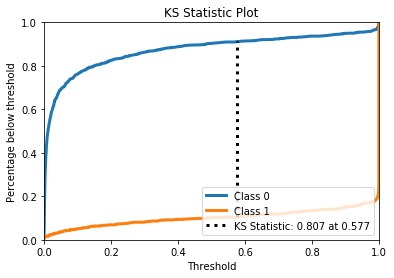

In [8]:
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score, roc_auc_score
import scikitplot as skplt
%matplotlib inline

predicted = model.predict([x_test])
true = []
pred = []
for i in range(len(predicted)):
    p_tmp = predicted[i][1]
    t_tmp = np.argmax(y_test[i], -1)
    pred.append(p_tmp)
    true.append(t_tmp)
pred = np.array(pred)
true = np.array(true)
skplt.metrics.plot_ks_statistic(np.array(true), list(zip(1-pred, pred)))

print("precision_score: ", precision_score(true, pred>=0.577))
print("recall_score: ", recall_score(true, pred>=0.577))
print("f1_score: ", f1_score(true, pred>=0.577))
print("roc_auc_score: ", roc_auc_score(true, pred))

In [8]:
from keras.models import model_from_json
# load json and create model
json_file = open('%s.json' % model_name, 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)
# load weights into new model
model.load_weights("%s.best.hdf5" % model_name)
print("Loaded model from disk")

model.compile(loss='binary_crossentropy',
              optimizer='sgd',
              metrics=['acc'])

Loaded model from disk


In [9]:
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score, roc_auc_score

predicted = model.predict([x_test])
true = []
pred = []
for i in range(len(predicted)):
    p_tmp = np.argmax(predicted[i], axis=-1)
    t_tmp = np.argmax(y_test[i], -1)
    pred.append(p_tmp)
    true.append(t_tmp)

print(precision_score(true, pred))
print(recall_score(true, pred))
print(roc_auc_score(true, pred))
print(f1_score(true, pred))

0.8963553530751709
0.8591703056768559
0.891156098784374
0.8773690078037905


In [9]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
fpr, tpr, _ = roc_curve(true, predicted[:,1])
np.save('fpr_%s.npy' % model_name, fpr)
np.save('tpr_%s.npy' % model_name, tpr)